<a href="https://colab.research.google.com/github/MaliheDahmardeh/state-house-price-analysis-SM/blob/main/state-house-price-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [380]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import math
import statistics
from statistics import median
from fractions import Fraction as fr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [381]:
!ls

sample_data  State_house_prices_ts.csv


In [382]:
df = pd.read_csv('State_house_prices_ts.csv', sep =',',parse_dates=['Date'])#.sort_values(by='Date', ascending=True , inplace=False)

In [383]:
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
0,2001-02-28,Alabama,70100.0,58700.0,95900.0,178700.0,248100.0,92500.0
1,2001-02-28,Alaska,97300.0,126400.0,177300.0,219800.0,282500.0,183300.0
2,2001-02-28,Arizona,75800.0,110200.0,126600.0,168100.0,250500.0,136900.0
3,2001-02-28,Arkansas,65100.0,64500.0,90300.0,156700.0,245300.0,74400.0
4,2001-02-28,California,146900.0,182700.0,218400.0,293700.0,405100.0,239900.0
...,...,...,...,...,...,...,...,...
13207,1999-12-31,Virginia,80800.0,84400.0,114300.0,191000.0,266500.0,125100.0
13208,1999-12-31,Washington,115300.0,131300.0,164400.0,218700.0,254000.0,165600.0
13209,1999-12-31,WestVirginia,NaN,NaN,60900.0,80200.0,90000.0,48100.0
13210,1999-12-31,Wisconsin,80800.0,89800.0,114400.0,143400.0,165400.0,113700.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [384]:
print('columns:', df.columns)
print('')
print('indexes:', df.index)
print('')
print('values:', df.values)

columns: Index(['Date', 'RegionName', 'Price_1bedroom', 'Price_2bedroom',
       'Price_3bedroom', 'Price_4bedroom', 'Price_5BedroomOrMore',
       'Price_SingleFamilyResidence'],
      dtype='object')

indexes: RangeIndex(start=0, stop=13212, step=1)

values: [[Timestamp('2001-02-28 00:00:00') 'Alabama' 70100.0 ... 178700.0
  248100.0 92500.0]
 [Timestamp('2001-02-28 00:00:00') 'Alaska' 97300.0 ... 219800.0 282500.0
  183300.0]
 [Timestamp('2001-02-28 00:00:00') 'Arizona' 75800.0 ... 168100.0
  250500.0 136900.0]
 ...
 [Timestamp('1999-12-31 00:00:00') 'WestVirginia' nan ... 80200.0 90000.0
  48100.0]
 [Timestamp('1999-12-31 00:00:00') 'Wisconsin' 80800.0 ... 143400.0
  165400.0 113700.0]
 [Timestamp('1999-12-31 00:00:00') 'Wyoming' nan ... 116600.0 nan
  104100.0]]


In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13212 entries, 0 to 13211
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13212 non-null  datetime64[ns]
 1   RegionName                   13212 non-null  object        
 2   Price_1bedroom               10605 non-null  float64       
 3   Price_2bedroom               11745 non-null  float64       
 4   Price_3bedroom               12787 non-null  float64       
 5   Price_4bedroom               12359 non-null  float64       
 6   Price_5BedroomOrMore         11814 non-null  float64       
 7   Price_SingleFamilyResidence  12438 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 825.9+ KB


In [386]:
df.duplicated().sum()  

0

In [387]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2607
Price_2bedroom                 1467
Price_3bedroom                  425
Price_4bedroom                  853
Price_5BedroomOrMore           1398
Price_SingleFamilyResidence     774
dtype: int64

In [388]:
df.loc[df.isnull().sum(axis=1) > 5]

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
16,2001-02-28,Kansas,NaN,NaN,NaN,NaN,NaN,NaN
398,2010-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
450,2011-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
502,2013-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
554,2014-02-28,UnitedStates,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13066,1997-12-31,Alaska,NaN,NaN,NaN,NaN,NaN,NaN
13080,1997-12-31,Kansas,NaN,NaN,NaN,NaN,NaN,NaN
13120,1998-12-31,DistrictofColumbia,NaN,NaN,NaN,NaN,NaN,NaN
13128,1998-12-31,Kansas,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:
df=df[(df.RegionName != 'UnitedStates')]

In [390]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2512
Price_2bedroom                 1372
Price_3bedroom                  330
Price_4bedroom                  758
Price_5BedroomOrMore           1303
Price_SingleFamilyResidence     679
dtype: int64

In [391]:
df = df.fillna(df.median())
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
0,2001-02-28,Alabama,70100.0,58700.0,95900.0,178700.0,248100.0,92500.0
1,2001-02-28,Alaska,97300.0,126400.0,177300.0,219800.0,282500.0,183300.0
2,2001-02-28,Arizona,75800.0,110200.0,126600.0,168100.0,250500.0,136900.0
3,2001-02-28,Arkansas,65100.0,64500.0,90300.0,156700.0,245300.0,74400.0
4,2001-02-28,California,146900.0,182700.0,218400.0,293700.0,405100.0,239900.0
...,...,...,...,...,...,...,...,...
13207,1999-12-31,Virginia,80800.0,84400.0,114300.0,191000.0,266500.0,125100.0
13208,1999-12-31,Washington,115300.0,131300.0,164400.0,218700.0,254000.0,165600.0
13209,1999-12-31,WestVirginia,100400.0,115400.0,60900.0,80200.0,90000.0,48100.0
13210,1999-12-31,Wisconsin,80800.0,89800.0,114400.0,143400.0,165400.0,113700.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [392]:
print('Total number of States :',df['RegionName'].nunique())
print('-------------')
print('Name of the States :',df['RegionName'].unique(),sep='\n')

Total number of States : 51
-------------
Name of the States :
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'DistrictofColumbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'NewHampshire'
 'NewJersey' 'NewMexico' 'NewYork' 'NorthCarolina' 'Ohio' 'Oklahoma'
 'Oregon' 'Pennsylvania' 'RhodeIsland' 'SouthCarolina' 'SouthDakota'
 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington'
 'WestVirginia' 'Wisconsin' 'Wyoming' 'NorthDakota']


In [393]:
df.isnull().sum()

Date                           0
RegionName                     0
Price_1bedroom                 0
Price_2bedroom                 0
Price_3bedroom                 0
Price_4bedroom                 0
Price_5BedroomOrMore           0
Price_SingleFamilyResidence    0
dtype: int64

In [394]:
df.describe()

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
count,13117.000000,13117.000000,13117.000000,13117.000000,1.311700e+04,13117.000000
mean,113869.833041,133101.044446,166412.136922,242337.035908,3.201838e+05,172764.267744
std,55288.851091,68650.601946,79300.508242,103277.871520,1.619648e+05,90020.814705
min,30900.000000,32800.000000,49600.000000,64700.000000,6.860000e+04,37900.000000
25%,79400.000000,89000.000000,117100.000000,177500.000000,2.237000e+05,116100.000000
50%,100400.000000,115400.000000,141200.000000,218000.000000,2.880000e+05,147300.000000
75%,132200.000000,160000.000000,201600.000000,276200.000000,3.539000e+05,208000.000000
max,390200.000000,542400.000000,639700.000000,850400.000000,1.497000e+06,737500.000000


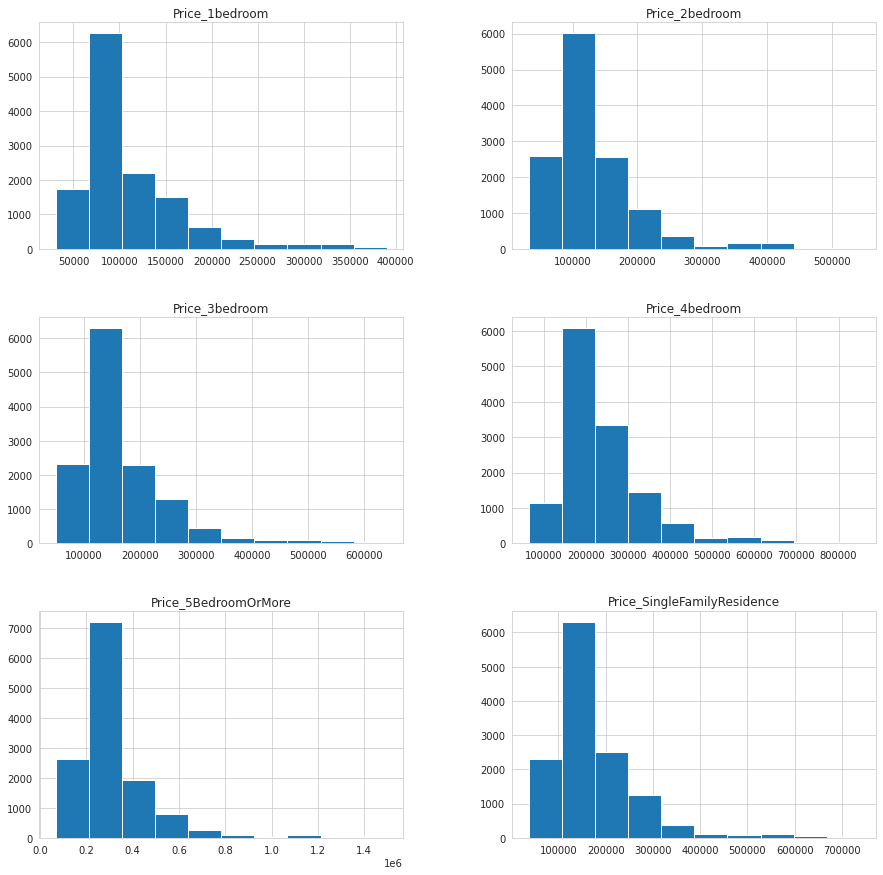

In [395]:
df_hist = df.drop(columns=['Date'],axis=1)
df_hist.hist(figsize=(15,15));

#Data manipulation

In [396]:
#
house_price_by_region= pd.pivot_table(data=df, index='Date', columns='RegionName',values=['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom','Price_5BedroomOrMore','Price_SingleFamilyResidence'], aggfunc='sum')

In [397]:
display(house_price_by_region)
display(type(house_price_by_region))
display(house_price_by_region.dtypes)
display(house_price_by_region.index)

Price_1bedroom                                                    \
RegionName        Alabama    Alaska   Arizona Arkansas California  Colorado   
Date                                                                          
1996-04-30        61500.0       NaN   59200.0  53000.0    93700.0   77800.0   
1996-05-31        60400.0       NaN   59200.0  53300.0    92900.0   77100.0   
1996-06-30        59900.0       NaN   59200.0  53400.0    92000.0   76100.0   
1996-07-31        59200.0       NaN   59500.0  53100.0    91600.0   75400.0   
1996-08-31        58600.0       NaN   59500.0  52900.0    91300.0   75000.0   
...                   ...       ...       ...      ...        ...       ...   
2017-08-31        91900.0  129300.0  115300.0  96300.0   357100.0  222200.0   
2017-09-30        93000.0  129400.0  116500.0  97300.0   359600.0  222900.0   
2017-10-31        93700.0  129500.0  117600.0  98300.0   362900.0  223800.0   
2017-11-30        94500.0  130400.0  118500.0  98900.0   367700.0  224400.0   
2017-12-31        95200.0  131400.0  118600.0  99500.0   371700.0  224500.0   

                                                               ...  \
RegionName Connecticut  Delaware DistrictofColumbia   Florida  ...   
Date                                                           ...   
1996-04-30     64700.0   90100.0                NaN   45400.0  ...   
1996-05-31     64400.0   89300.0                NaN   45100.0  ...   
1996-06-30     64100.0   89000.0                NaN   44700.0  ...   
1996-07-31     63400.0   86900.0                NaN   44400.0  ...   
1996-08-31     62900.0   83800.0                NaN   44000.0  ...   
...                ...       ...                ...       ...  ...   
2017-08-31    123300.0  134600.0           386600.0  112600.0  ...   
2017-09-30    124800.0  133900.0           385900.0  113900.0  ...   
2017-10-31    125600.0  135300.0           385700.0  114900.0  ...   
2017-11-30    126300.0  139200.0           385000.0  115700.0  ...   
2017-12-31    127100.0  142900.0           384700.0  115900.0  ...   

           Price_SingleFamilyResidence                                \
RegionName                 SouthDakota Tennessee     Texas      Utah   
Date                                                                   
1996-04-30                         NaN   69300.0  147300.0  129500.0   
1996-05-31                     83500.0   69700.0  147300.0  129900.0   
1996-06-30                     82600.0   70100.0  147300.0  130500.0   
1996-07-31                     82200.0   70400.0  147300.0  131000.0   
1996-08-31                     82500.0   70700.0  147300.0  131600.0   
...                                ...       ...       ...       ...   
2017-08-31                    173800.0  142500.0  170700.0  261600.0   
2017-09-30                    174900.0  143400.0  171800.0  263200.0   
2017-10-31                    175700.0  143900.0  172900.0  265000.0   
2017-11-30                    176900.0  144400.0  173900.0  267500.0   
2017-12-31                    178700.0  145000.0  175000.0  270600.0   

                                                                            
RegionName   Vermont  Virginia Washington WestVirginia Wisconsin   Wyoming  
Date                                                                        
1996-04-30       NaN  110000.0   136900.0      37900.0  147300.0       NaN  
1996-05-31  147300.0  110700.0   137100.0      38600.0  147300.0       NaN  
1996-06-30  147300.0  111100.0   137400.0      39300.0  147300.0       NaN  
1996-07-31  147300.0  111300.0   137600.0      39800.0  147300.0       NaN  
1996-08-31  147300.0  111500.0   137700.0      40100.0  147300.0       NaN  
...              ...       ...        ...          ...       ...       ...  
2017-08-31  227800.0  235800.0   342900.0     101900.0  167700.0  195600.0  
2017-09-30  227400.0  236600.0   345600.0     102100.0  168700.0  196500.0  
2017-10-31  226800.0  237400.0   348400.0     102600.0  169600.0  1

pandas.core.frame.DataFrame

                             RegionName  
Price_1bedroom               Alabama         float64
                             Alaska          float64
                             Arizona         float64
                             Arkansas        float64
                             California      float64
                                              ...   
Price_SingleFamilyResidence  Virginia        float64
                             Washington      float64
                             WestVirginia    float64
                             Wisconsin       float64
                             Wyoming         float64
Length: 306, dtype: object

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [398]:
# Converting the index as date with monthly frequency
house_price_by_region.index = pd.to_datetime(house_price_by_region.index)
house_price_by_region= house_price_by_region.asfreq('M')
display(house_price_by_region.index)
display(house_price_by_region)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

Price_1bedroom                                                    \
RegionName        Alabama    Alaska   Arizona Arkansas California  Colorado   
Date                                                                          
1996-04-30        61500.0       NaN   59200.0  53000.0    93700.0   77800.0   
1996-05-31        60400.0       NaN   59200.0  53300.0    92900.0   77100.0   
1996-06-30        59900.0       NaN   59200.0  53400.0    92000.0   76100.0   
1996-07-31        59200.0       NaN   59500.0  53100.0    91600.0   75400.0   
1996-08-31        58600.0       NaN   59500.0  52900.0    91300.0   75000.0   
...                   ...       ...       ...      ...        ...       ...   
2017-08-31        91900.0  129300.0  115300.0  96300.0   357100.0  222200.0   
2017-09-30        93000.0  129400.0  116500.0  97300.0   359600.0  222900.0   
2017-10-31        93700.0  129500.0  117600.0  98300.0   362900.0  223800.0   
2017-11-30        94500.0  130400.0  118500.0  98900.0   367700.0  224400.0   
2017-12-31        95200.0  131400.0  118600.0  99500.0   371700.0  224500.0   

                                                               ...  \
RegionName Connecticut  Delaware DistrictofColumbia   Florida  ...   
Date                                                           ...   
1996-04-30     64700.0   90100.0                NaN   45400.0  ...   
1996-05-31     64400.0   89300.0                NaN   45100.0  ...   
1996-06-30     64100.0   89000.0                NaN   44700.0  ...   
1996-07-31     63400.0   86900.0                NaN   44400.0  ...   
1996-08-31     62900.0   83800.0                NaN   44000.0  ...   
...                ...       ...                ...       ...  ...   
2017-08-31    123300.0  134600.0           386600.0  112600.0  ...   
2017-09-30    124800.0  133900.0           385900.0  113900.0  ...   
2017-10-31    125600.0  135300.0           385700.0  114900.0  ...   
2017-11-30    126300.0  139200.0           385000.0  115700.0  ...   
2017-12-31    127100.0  142900.0           384700.0  115900.0  ...   

           Price_SingleFamilyResidence                                \
RegionName                 SouthDakota Tennessee     Texas      Utah   
Date                                                                   
1996-04-30                         NaN   69300.0  147300.0  129500.0   
1996-05-31                     83500.0   69700.0  147300.0  129900.0   
1996-06-30                     82600.0   70100.0  147300.0  130500.0   
1996-07-31                     82200.0   70400.0  147300.0  131000.0   
1996-08-31                     82500.0   70700.0  147300.0  131600.0   
...                                ...       ...       ...       ...   
2017-08-31                    173800.0  142500.0  170700.0  261600.0   
2017-09-30                    174900.0  143400.0  171800.0  263200.0   
2017-10-31                    175700.0  143900.0  172900.0  265000.0   
2017-11-30                    176900.0  144400.0  173900.0  267500.0   
2017-12-31                    178700.0  145000.0  175000.0  270600.0   

                                                                            
RegionName   Vermont  Virginia Washington WestVirginia Wisconsin   Wyoming  
Date                                                                        
1996-04-30       NaN  110000.0   136900.0      37900.0  147300.0       NaN  
1996-05-31  147300.0  110700.0   137100.0      38600.0  147300.0       NaN  
1996-06-30  147300.0  111100.0   137400.0      39300.0  147300.0       NaN  
1996-07-31  147300.0  111300.0   137600.0      39800.0  147300.0       NaN  
1996-08-31  147300.0  111500.0   137700.0      40100.0  147300.0       NaN  
...              ...       ...        ...          ...       ...       ...  
2017-08-31  227800.0  235800.0   342900.0     101900.0  167700.0  195600.0  
2017-09-30  227400.0  236600.0   345600.0     102100.0  168700.0  196500.0  
2017-10-31  226800.0  237400.0   348400.0     102600.0  169600.0  1

#Functions(plot)

In [399]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [400]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))
    if custom_ylim != None:
        plt.ylim(custom_ylim[0], custom_ylim[1])
    plt.xlim(df.index[0],df.index[-1])
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [401]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [402]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [403]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

#Data exploration

#How is the tren of price of houses in the united states during the years:

In [404]:
price_total = house_price_by_region.sum(axis=1)
price_total_by_year = price_total.resample('Y').sum()
price_total_by_year.index = price_total_by_year.index.year
price_total_by_year = price_total_by_year/1000000
display(price_total_by_year)

Date
1996    300.9636
1997    414.7341
1998    457.2260
1999    489.2364
2000    521.5260
2001    557.3244
2002    595.9621
2003    644.6445
2004    712.1936
2005    802.8685
2006    855.0743
2007    858.5791
2008    820.4451
2009    775.8557
2010    743.8188
2011    716.3642
2012    713.0059
2013    746.1966
2014    780.8204
2015    812.8659
2016    851.5603
2017    895.8147
dtype: float64

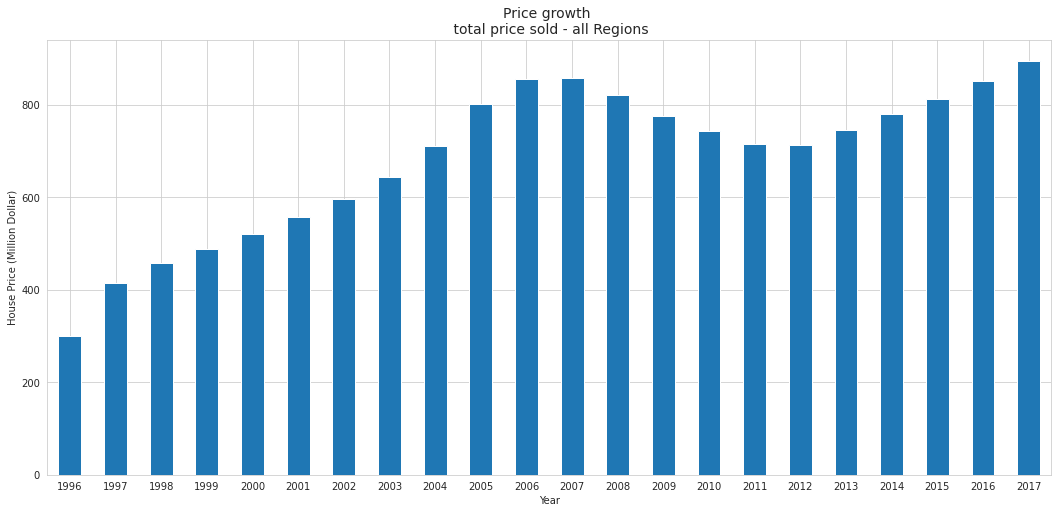

In [405]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_year.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='Year')
plt.title('Price growth \n total price sold - all Regions', fontsize=14)
plt.show()

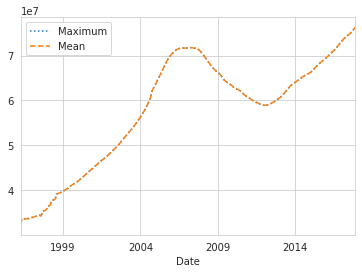

In [406]:
Maximum = price_total.resample('M').max() 
Maximum.plot(style=':')

Mean = price_total.resample('M').mean()
Mean.plot(style='--')

plt.legend(['Maximum', 'Mean'],loc='upper left');

#In what States the house price is more expensive:

In [407]:
price_total_by_Region = house_price_by_region.sum(axis=0)
price_total_by_regions  = pd.Series(price_total_by_Region , name='RegionName')
price_total_by_regions = price_total_by_Region.sort_values(ascending=False).head(10)

display(price_total_by_regions)

                             RegionName        
Price_5BedroomOrMore         DistrictofColumbia    238844700.0
                             Hawaii                160450300.0
                             California            146523400.0
                             Connecticut           140452000.0
                             Massachusetts         137645000.0
Price_4bedroom               Hawaii                137181800.0
Price_SingleFamilyResidence  Hawaii                124310700.0
Price_4bedroom               DistrictofColumbia    123675800.0
Price_5BedroomOrMore         NewJersey             116219100.0
                             Virginia              111853600.0
dtype: float64

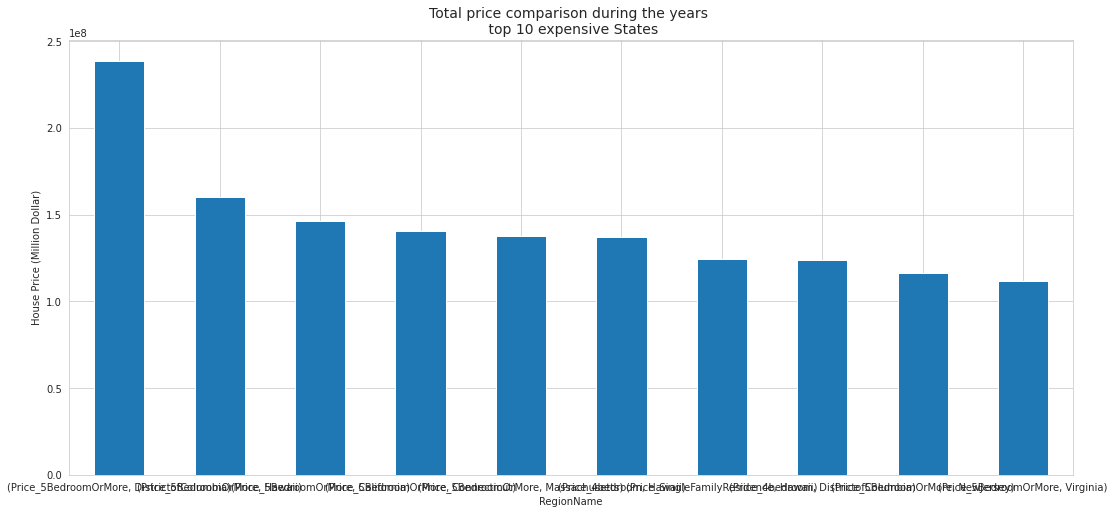

In [408]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_regions.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='RegionName')
plt.title('Total price comparison during the years \n top 10 expensive States', fontsize=14)
plt.show()

ValueError: ignored

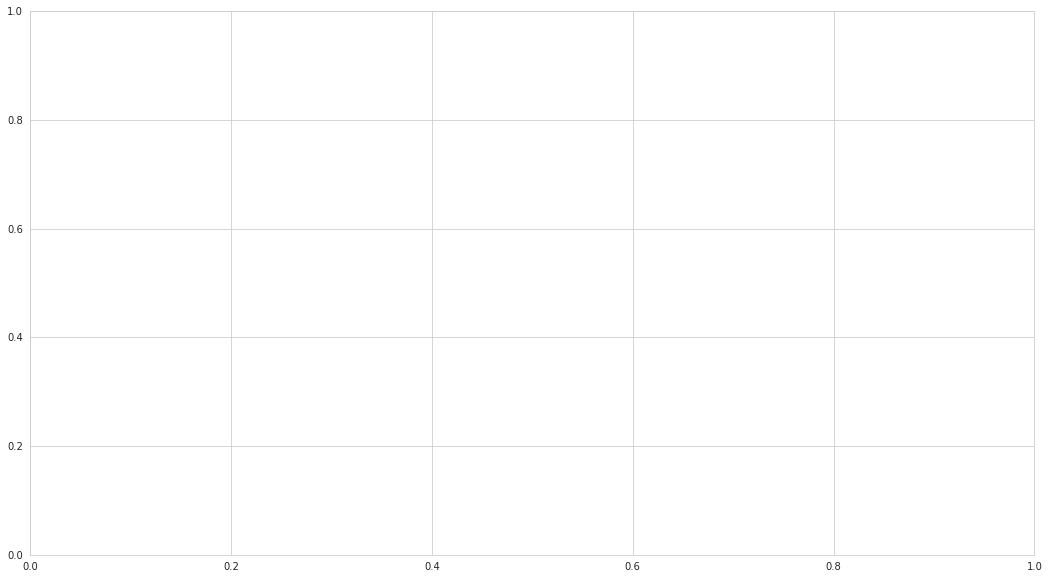

In [410]:

fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="RegionName", y="houseprice", data=df, palette='Paired', width=0.65)
plt.title('Price oh houses', fontsize=14)
plt.xlabel('States')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('price of houses (total amount/year)')
plt.show()

In [416]:
price_groupby = df[['Date','RegionName','houseprice']].groupby(['Date','RegionName']).sum()
price_groupby['year'] = (price_groupby.index).to_series().map(lambda x : x[0].year)
#rice_groupby['weekday'] = (price_groupby.index).to_series().map(lambda x : x[0].isoweekday())
price_groupby['month'] = (price_groupby.index).to_series().map(lambda x : x[0].month)
display(price_groupby)

KeyError: ignored

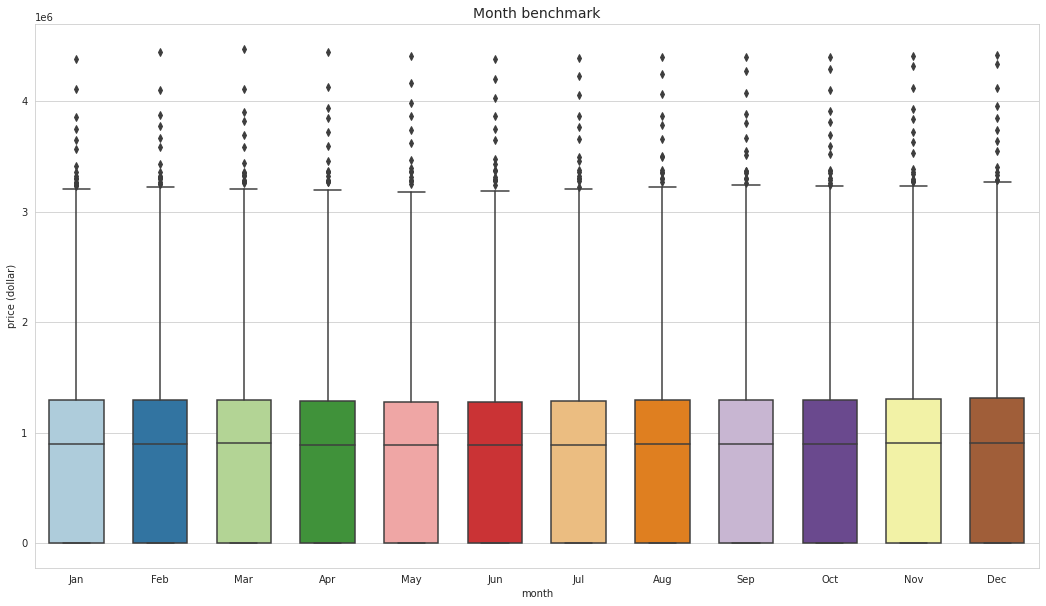

In [414]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='month', y='houseprice', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('price (dollar)')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

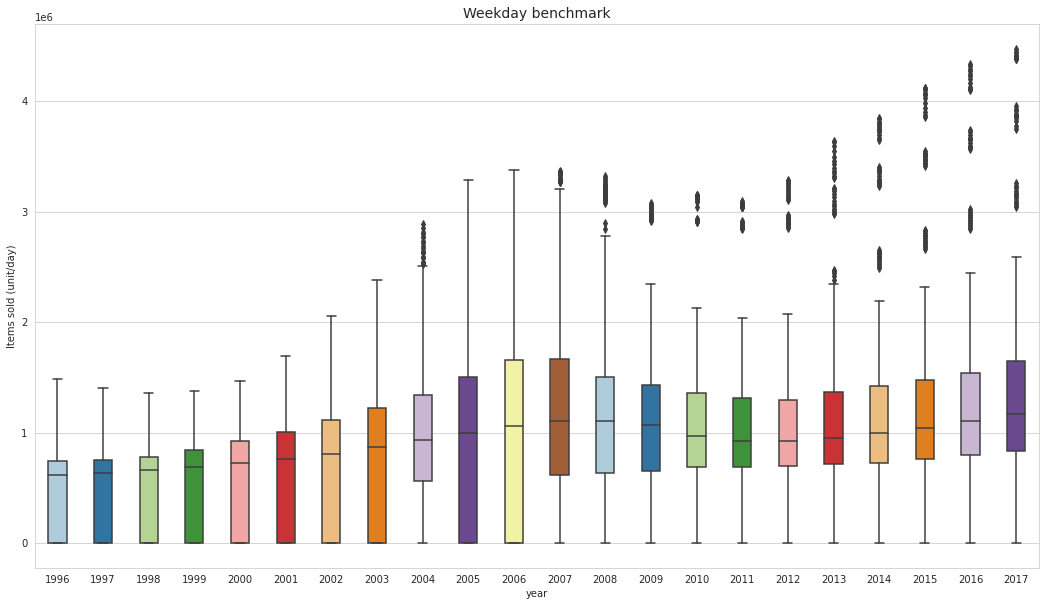

In [413]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='year', y='houseprice', palette='Paired', width=0.4)
plt.title('Weekday benchmark', fontsize=14)
plt.ylabel('Items sold (unit/day)')
ax.set_xticklabels('{}'.format(i) for i in range(1996,2018))
plt.show()

#Discriptive Statistics-Time series Analysis

In [411]:
descriptive_stat = house_price_by_region.describe().T

Q1 = house_price_by_region.quantile(0.25)
Q3 = house_price_by_region.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (house_price_by_region < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (house_price_by_region > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

count       mean       std  \
                            RegionName                                 
Price_1bedroom              Alabama       261.0   83017.24  13773.65   
                            Alaska        244.0  120267.62  17405.18   
                            Arizona       261.0   93820.69  26959.54   
                            Arkansas      261.0   75100.00  11514.36   
                            California    261.0  224089.66  82945.73   
...                                         ...        ...       ...   
Price_SingleFamilyResidence Virginia      261.0  188557.85  46303.12   
                            Washington    261.0  231542.91  56931.06   
                            WestVirginia  261.0   69383.14  21134.04   
                            Wisconsin     261.0  142195.40  16996.27   
                            Wyoming       237.0  164079.75  35495.58   

                                               min       25%       50%  \
                            RegionName                                   
Price_1bedroom              Alabama        57700.0   71700.0   88100.0   
                            Alaska         89800.0  102675.0  123550.0   
                            Arizona        59200.0   72200.0   87100.0   
                            Arkansas       52900.0   64500.0   80200.0   
                            California     91000.0  159500.0  219500.0   
...                                            ...       ...       ...   
Price_SingleFamilyResidence Virginia      110000.0  140000.0  206500.0   
                            Washington    136900.0  180300.0  234200.0   
                            WestVirginia   37900.0   49800.0   64300.0   
                            Wisconsin      99000.0  133500.0  147100.0   
                            Wyoming        97200.0  127200.0  178800.0   

                                               75%       max     range  \
                            RegionName                                   
Price_1bedroom              Alabama        93400.0  102300.0   44600.0   
                            Alaska        129875.0  150700.0   60900.0   
                            Arizona       108600.0  153200.0   94000.0   
                            Arkansas       84100.0   99500.0   46600.0   
                            California    297100.0  371700.0  280700.0   
...                                            ...       ...       ...   
Price_SingleFamilyResidence Virginia      223900.0  251000.0  141000.0   
                            Washington    277400.0  352800.0  215900.0   
                            WestVirginia   90100.0  103300.0   65400.0   
                            Wisconsin     156300.0  170200.0   71200.0   
                            Wyoming       193200.0  212900.0  115700.0   

                                               IQR  outlier_lower_count  \
                            RegionName                                    
Price_1bedroom              Alabama        21700.0                    0   
                            Alaska         27200.0                    0   
                            Arizona        36400.0                    0   
                            Arkansas       19600.0                    0   
                            California    137600.0                    0   
...                                            ...                  ...   
Price_SingleFamilyResidence Virginia       83900.0                    0   
                            Washington     97100.0                    0   
                            WestVirginia   40300.0                    0   
                            Wisconsin      22800.0                    1   
                            Wyoming        66000.0                    0   

                                          outlier_upper_count  \
                            RegionName                          
Price_1bedroom              Alabama                         0   
        

In [412]:
Hawaii_ts = pd.DataFrame(house_price_by_region['Hawaii'])

KeyError: ignored

In [ ]:
plotTS(Hawaii_ts, column='Hawaii', custom_ylim=(0,6000), title='House_price', xlabel='Date', ylabel='price')

In [ ]:
Alabama_ts = pd.DataFrame(house_price_by_region['Alabama'])

In [ ]:
plotTS(Alabama_ts, column='Alabama', custom_ylim=(0,6000), title='House_price', xlabel='Date', ylabel='price')

#Analysis of State,Hawaii

In [ ]:
fig = Hawaii_ts.plot(figsize=(16,4), title='house price 1996 [Hawaii]')
fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('Items sold (unit/day)')
plt.ylim(0,6000)
plt.show()

#Stationarity

In [ ]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type, store=True)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [ ]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='c')

In [ ]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='ct')